<a href="https://colab.research.google.com/github/AbrahamKong/CMPE257-NLP_AlternusVera/blob/master/Merging_models_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Abraham_Model**

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def set_column_names(url, column_1, column_2, need_column_name, LiarLiar):
  dataframe = pd.read_csv(url, delimiter="\t")
  if (need_column_name == True):
    if(LiarLiar == True):
      dataframe.columns =['id', 'label', 'news', 'subjects', 'speaker', 'title', 'state', 'party-affiliation', 'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'justification']
    else:
      dataframe.columns =['unname', 'id', 'label', 'news', 'subjects', 'speaker', 'title', 'state', 'party-affiliation', 'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'venue','justification']
  dataframe = dataframe[[column_1, column_2]]
  return dataframe

In [ ]:
train_data_liarliarplus = set_column_names("/content/drive/My Drive/ML-Spring-2022/Data Miners/Assignments/Pooja/Assignment - 12/LiarLiarPlus/train.tsv", "news", "label", True, False)
test_data_liarliarplus = set_column_names("/content/drive/My Drive/ML-Spring-2022/Data Miners/Assignments/Pooja/Assignment - 12/LiarLiarPlus/test.tsv", "news", "label", True, False)
valid_data_liarliarplus = set_column_names("/content/drive/My Drive/ML-Spring-2022/Data Miners/Assignments/Pooja/Assignment - 12/LiarLiarPlus/valid.tsv", "news", "label", True, False)

In [ ]:
politifact_df = pd.read_csv('/content/politifact_abraham.csv')

In [ ]:
politifact_df.head(10)

,Unnamed: 0,Statement,Link,Date,Source,Label
0,0,"The Biden administration has been ""recklessly ...",https://www.politifact.com/factchecks/2022/may...,"May 13, 2022",Tom Tiffany,barely-true
1,1,Suggests Amber Heard snorted cocaine while on ...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,pants-fire
2,2,The infant formula shortage was purposely crea...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,false
3,3,"""Kari Lake has been appearing at rallies with ...",https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Aaron Lieberman,barely-true
4,4,“Is ANYONE asking how Ron DeSantis was worth $...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Tweets,false
5,5,"An adenovirus is a combination of viruses, gas...",https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,false
6,6,“CO2 is not a pollutant.”,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Suburban Virginia Republican Coalition,false
7,7,Supreme Court Justices Amy Coney Barrett and S...,https://www.politifact.com/factchecks/2022/may...,"May 12, 2022",Facebook posts,false
8,8,"Says photo shows ""one of Tesla's lithium suppl...",https://www.politifact.com/factchecks/2022/may...,"May 11, 2022",Facebook posts,false
9,9,"Due to U.S. Senate rules, Democrats need ""more...",https://www.politifact.com/factchecks/2022/may...,"May 11, 2022",Kelda Helen Roys,true


In [ ]:
def cleaning(raw_news):
    # import nltk
    # nltk.download('punkt')
    # nltk.download('wordnet')
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", str(raw_news))
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [ ]:
# Reference https://gist.github.com/AhmedHani/81bd40ff3ce4d9131f02c89fe099d490
def get_sentences(text):
    return re.split('\? |, |!|\n', text)

def get_words(sentences):
    return sum([sentence.split() for sentence in sentences], [])

def get_average_word_length(words):
    return sum([len(word) for word in words]) // len(words)
  
def get_average_word_based_sentence_length(sentences):
    return sum([len(sentence.split()) for sentence in sentences]) // len(sentences)

def get_average_chars_based_sentence_length(sentences):
    return sum([len(sentence) for sentence in sentences]) // len(sentences)
  
def get_punctuations_count(text):
    return len([c for c in text if c in string.punctuation])

def vocab_richness_ratio(words):
  return float(len(set(words))) / float(len(words))

def shannon_entropy(words):
  import math
  import numpy as np
  import scipy as sc
  from collections import Counter

  length = len(words)
  freqs = Counter(words)
  distribution = np.array(list(freqs.values()))
  distribution = np.true_divide(distribution, length)
    
  E = sc.stats.entropy(distribution, base=2)

  return E

def syllables_count(words, vowels="aeiouy"):
  total_count = 0.0

  for word in words:
    word = word.lower()
    count = 0
  
    if word[0] in vowels:
      count += 1
  
    for i in range(1, len(word)):
      if word[i] in vowels and word[i - 1] not in vowels:
        count += 1

        if word.endswith("e"):
          count -= 1
    
    if count == 0:
      count = 1
    
    total_count += count

  return total_count, (total_count // len(words)) # Average

def flesch_reading_ease(words, sentences, avg_word_based_sentence_length):
  # 206.835 - (1.015 * Average Number of Words Per Sentence) - (84.6 * Average Syllables Count Per Sentence)
  _, avg_syllables_count = syllables_count(words)

  return 206.835 - (1.015 * avg_word_based_sentence_length) - (84.6 * avg_syllables_count)

In [ ]:
def mergeLabel(r):
  '''
  Merge the PolitiFacts's 8 labels to Liar Liar's 6 data label
  Change full-flop to pants-fire, and half-flip to barely-true
  '''

  # v = r['Label']

  if (r == 'half-flip'):
      r = 'pants-fire'
  if (r == 'full-flop'):
      r = 'barely-true'
  return r 


In [ ]:
def mergeNumberLabel(r):
        '''
        Convert labels to Integers
        '''

        # v = r['Label']

        if (r == 'true'):
            r = 0
        if (r == 'mostly-true'):
            r = 1
        if (r == 'half-true'):
            r = 2
        if (r == 'barely-true'):
            r = 3
        if (r == 'false'):
            r = 4
        if (r == 'pants-fire'):
            r = 5
        if (r == 'half-flip'):
            r = 5
        if (r == 'full-flop'):
            r = 3
        return r 

In [ ]:
#politifact_df['Label'] = politifact_df["Label"].apply(mergeNumberLabel)
train_data_liarliarplus['label'] = train_data_liarliarplus["label"].apply(mergeNumberLabel)
test_data_liarliarplus['label'] = test_data_liarliarplus["label"].apply(mergeNumberLabel)
valid_data_liarliarplus['label'] = valid_data_liarliarplus["label"].apply(mergeNumberLabel)

In [ ]:
def corpursStyleEval(df): 
  train_final = df.copy()

  train_final['label'] = train_final["label"].apply(mergeNumberLabel)

  train_final['sentences'] = train_final['clean'].apply(get_sentences)
  # train_final['n_sentences'] = politifact_df["sentences"].apply(len)
  # print(f'number of sentences: {n_sentences}')
          
  train_final['words'] = train_final['sentences'].apply(get_words)
  # train_final['n_words'] = len(train_final['words'])
  # print(f'number of words: {n_words}')
          
  train_final['avg_word_length'] = train_final['words'].apply(get_average_word_length)
  # print(f'average word length: {avg_word_length}')
          
  train_final['avg_word_based_sentence_length'] = train_final['sentences'].apply(get_average_word_based_sentence_length)
  # print(f'average word-based sentence length: {avg_word_based_sentence_length}')
          
  train_final['avg_char_based_sentence_length'] = train_final['sentences'].apply(get_average_chars_based_sentence_length)
  # print(f'average char-based sentence length: {avg_char_based_sentence_length}')
          
  train_final['punc_count'] = train_final['clean'].apply(get_punctuations_count)
  # print(f'punctuations count: {punc_count}')

  train_final['richness_ratio'] = train_final['words'].apply(vocab_richness_ratio)

  train_final['flesch_score']=0
  for i in range(train_final.shape[0]):
    train_final['flesch_score'][i] = flesch_reading_ease(train_final['words'][i], train_final['sentences'][i], train_final['avg_word_based_sentence_length'][i])

  return train_final[['clean', 'label', 'richness_ratio', 'flesch_score']].copy()

In [ ]:
import re
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.wordnet import WordNetLemmatizer

# politifact_df['clean'] = politifact_df["Statement"].apply(cleaning)
# politifact_df = corpursStyleEval(politifact_df)

train_data_liarliarplus['clean'] = train_data_liarliarplus["news"].apply(cleaning)
train_data_liarliarplus = corpursStyleEval(train_data_liarliarplus)

test_data_liarliarplus['clean'] = test_data_liarliarplus["news"].apply(cleaning)
test_data_liarliarplus = corpursStyleEval(test_data_liarliarplus)

valid_data_liarliarplus['clean'] = valid_data_liarliarplus["news"].apply(cleaning)
valid_data_liarliarplus = corpursStyleEval(valid_data_liarliarplus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# valid_data_liarliarplus.to_csv("llp_valid.csv")
# train_data_liarliarplus.to_csv("llp_train.csv")
# test_data_liarliarplus.to_csv("llp_test.csv")

valid_data_liarliarplus = pd.read_csv("llp_valid.csv")
train_data_liarliarplus = pd.read_csv("llp_train.csv")
test_data_liarliarplus= pd.read_csv("llp_test.csv")

In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import MinMaxScaler
import pickle

from tensorflow.keras.layers import *
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report

In [ ]:
politifact_df.to_csv('/content/final_abraham.csv')

In [ ]:
train_data_liarliarplus.head(1)

,Unnamed: 0,clean,label,richness_ratio,flesch_score
0,0,declin coal start start natur gas took start b...,2.0,0.857143,108


In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_data_liarliarplus.dropna(inplace = True)
test_data_liarliarplus.dropna(inplace = True)

train_final = train_data_liarliarplus[train_data_liarliarplus['flesch_score'].notna()]
X_train = train_final[['richness_ratio', 'flesch_score']].copy()
y_train = train_final['label']

test_final = test_data_liarliarplus[test_data_liarliarplus['flesch_score'].notna()]
X_test = test_final[['richness_ratio', 'flesch_score']].copy()
y_test = test_final['label']
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import joblib
joblib.dump(scaler, 'abraham_scaler.sav')

['abraham_scaler.sav']

In [ ]:
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [ ]:
X_train.shape

(10239, 1, 2)

In [ ]:
y_train.dropna

<bound method Series.dropna of 0        2.0
1        1.0
2        4.0
3        2.0
4        0.0
        ... 
10236    1.0
10237    1.0
10238    2.0
10239    4.0
10240    5.0
Name: label, Length: 10239, dtype: float64>

In [ ]:
from keras.regularizers import l2

sgd = SGD(lr=0.001, momentum=0.8)
def BiLstm():
    model = Sequential()
    model.add((LSTM(256, activation=activations.relu)))
    model.add(Dense(256, activation=activations.relu))
    model.add(Dense(128, activation=activations.relu))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=activations.relu))
    model.add(Dense(128, activation=activations.relu))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=activations.relu))
    model.add(Dense(64, activation=activations.relu))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=activations.relu))
    model.add(Dense(32, activation=activations.relu))
    model.add(Dense(6, activation=activations.softmax))
    model.build(input_shape = X_train.shape)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = BiLstm()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (10239, 256)              265216    
                                                                 
 dense_18 (Dense)            (10239, 256)              65792     
                                                                 
 dense_19 (Dense)            (10239, 128)              32896     
                                                                 
 dropout_6 (Dropout)         (10239, 128)              0         
                                                                 
 dense_20 (Dense)            (10239, 128)              16512     
                                                                 
 dense_21 (Dense)            (10239, 128)              16512     
                                                                 
 dropout_7 (Dropout)         (10239, 128)             

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=100, 
                   # callbacks=lrate, 
                    verbose=2)

Epoch 1/10
103/103 - 2s - loss: 1.7570 - accuracy: 0.2074 - val_loss: 1.7499 - val_accuracy: 0.2093 - 2s/epoch - 24ms/step
Epoch 2/10
103/103 - 2s - loss: 1.7568 - accuracy: 0.2065 - val_loss: 1.7504 - val_accuracy: 0.2093 - 2s/epoch - 21ms/step
Epoch 3/10
103/103 - 2s - loss: 1.7568 - accuracy: 0.2057 - val_loss: 1.7503 - val_accuracy: 0.2093 - 2s/epoch - 22ms/step
Epoch 4/10
103/103 - 2s - loss: 1.7573 - accuracy: 0.2054 - val_loss: 1.7502 - val_accuracy: 0.2093 - 2s/epoch - 23ms/step
Epoch 5/10
103/103 - 1s - loss: 1.7567 - accuracy: 0.2062 - val_loss: 1.7505 - val_accuracy: 0.2093 - 1s/epoch - 14ms/step
Epoch 6/10
103/103 - 1s - loss: 1.7564 - accuracy: 0.2020 - val_loss: 1.7511 - val_accuracy: 0.2093 - 1s/epoch - 14ms/step
Epoch 7/10
103/103 - 1s - loss: 1.7567 - accuracy: 0.2057 - val_loss: 1.7505 - val_accuracy: 0.2093 - 1s/epoch - 15ms/step
Epoch 8/10
103/103 - 2s - loss: 1.7566 - accuracy: 0.2075 - val_loss: 1.7498 - val_accuracy: 0.2093 - 2s/epoch - 15ms/step
Epoch 9/10
103/1

In [ ]:
import joblib
#model.save('/content/drive/My Drive/ML-Spring-2022/Data Miners/Assignments/Pooja/Assignment - 12/abraham_model.h5')
joblib.dump(model, 'abraham_model.sav')

INFO:tensorflow:Assets written to: ram://ccd8219a-6009-49a7-818f-a664de3ab390/assets


INFO:tensorflow:Assets written to: ram://ccd8219a-6009-49a7-818f-a664de3ab390/assets


['abraham_model.sav']

In [ ]:
def cleaning(raw_news):
  # import nltk
  # nltk.download('punkt')
  # nltk.download('wordnet')
  
  # 1. Remove non-letters/Special Characters and Punctuations
  news = re.sub("[^a-zA-Z]", " ", str(raw_news))
  
  # 2. Convert to lower case.
  news =  news.lower()
  
  # 3. Tokenize.
  news_words = nltk.word_tokenize( news)
  
  # 4. Convert the stopwords list to "set" data type.
  stops = set(nltk.corpus.stopwords.words("english"))
  
  # 5. Remove stop words. 
  words = [w for w in  news_words  if not w in stops]
  
  # 6. Lemmentize 
  wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
  
  # 7. Stemming
  stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
  
  # 8. Join the stemmed words back into one string separated by space, and return the result.
  return " ".join(stems)

def get_sentences(text):
    return re.split('\? |, |!|\n', text)

def get_words(sentences):
    return sum([sentence.split() for sentence in sentences], [])

def get_average_word_length(words):
    return sum([len(word) for word in words]) // len(words)
  
def get_average_word_based_sentence_length(sentences):
    return sum([len(sentence.split()) for sentence in sentences]) // len(sentences)

def get_average_chars_based_sentence_length(sentences):
    return sum([len(sentence) for sentence in sentences]) // len(sentences)
  
def get_punctuations_count(text):
    return len([c for c in text if c in string.punctuation])

def vocab_richness_ratio(words):
  return float(len(set(words))) / float(len(words))

def shannon_entropy(words):
  import math
  import numpy as np
  import scipy as sc
  from collections import Counter

  length = len(words)
  freqs = Counter(words)
  distribution = np.array(list(freqs.values()))
  distribution = np.true_divide(distribution, length)
    
  E = sc.stats.entropy(distribution, base=2)

  return E

def syllables_count(words, vowels="aeiouy"):
  total_count = 0.0

  for word in words:
    word = word.lower()
    count = 0
  
    if word[0] in vowels:
      count += 1
  
    for i in range(1, len(word)):
      if word[i] in vowels and word[i - 1] not in vowels:
        count += 1

        if word.endswith("e"):
          count -= 1
    
    if count == 0:
      count = 1
    
    total_count += count

  return total_count, (total_count // len(words)) # Average

def flesch_reading_ease(words, sentences, avg_word_based_sentence_length):
  # 206.835 - (1.015 * Average Number of Words Per Sentence) - (84.6 * Average Syllables Count Per Sentence)
  _, avg_syllables_count = syllables_count(words)

  return 206.835 - (1.015 * avg_word_based_sentence_length) - (84.6 * avg_syllables_count)

def mergeLabel(r):
  '''
  Merge the PolitiFacts's 8 labels to Liar Liar's 6 data label
  Change full-flop to pants-fire, and half-flip to barely-true
  '''

  # v = r['Label']

  if (r == 'half-flip'):
      r = 'pants-fire'
  if (r == 'full-flop'):
      r = 'barely-true'
  return r


def mergeNumberLabel(r):
  '''
  Convert labels to Integers
  '''

  # v = r['Label']

  if (r == 'true'):
      r = 0
  if (r == 'mostly-true'):
      r = 1
  if (r == 'half-true'):
      r = 2
  if (r == 'barely-true'):
      r = 3
  if (r == 'false'):
      r = 4
  if (r == 'pants-fire'):
      r = 5
  if (r == 'half-flip'):
      r = 5
  if (r == 'full-flop'):
      r = 3
  return r 


def corpursStyleEval(df): 
  train_final = df.copy()

  train_final['clean'] = train_final["news"].apply(cleaning)

  train_final['sentences'] = train_final['clean'].apply(get_sentences)
  # train_final['n_sentences'] = politifact_df["sentences"].apply(len)
  # print(f'number of sentences: {n_sentences}')
          
  train_final['words'] = train_final['sentences'].apply(get_words)
  # train_final['n_words'] = len(train_final['words'])
  # print(f'number of words: {n_words}')
          
  train_final['avg_word_length'] = train_final['words'].apply(get_average_word_length)
  # print(f'average word length: {avg_word_length}')
          
  train_final['avg_word_based_sentence_length'] = train_final['sentences'].apply(get_average_word_based_sentence_length)
  # print(f'average word-based sentence length: {avg_word_based_sentence_length}')
          
  train_final['avg_char_based_sentence_length'] = train_final['sentences'].apply(get_average_chars_based_sentence_length)
  # print(f'average char-based sentence length: {avg_char_based_sentence_length}')
          
  train_final['punc_count'] = train_final['clean'].apply(get_punctuations_count)
  # print(f'punctuations count: {punc_count}')

  train_final['richness_ratio'] = train_final['words'].apply(vocab_richness_ratio)

  train_final['flesch_score']=0
  for i in range(train_final.shape[0]):
    train_final['flesch_score'][i] = flesch_reading_ease(train_final['words'][i], train_final['sentences'][i], train_final['avg_word_based_sentence_length'][i])
    
  return train_final[['clean', 'label', 'richness_ratio', 'flesch_score']].copy()

In [ ]:
def get_final_AbModel(dataframe_final):
  final_model= joblib.load("/content/abraham_final_2.sav")
  #prediction =  np.argmax(final_model.predict(dataframe_final),axis=1)
  logits =  final_model.predict(dataframe_final)
  return logits

In [ ]:
test_data = pd.read_csv("/content/test_data.csv")

import joblib

final_dataset = corpursStyleEval(test_data.copy())
scalar = joblib.load('/content/abraham_scaler.sav')
final_dataset_scaled = scalar.transform(train_final[['richness_ratio', 'flesch_score']])
final_dataset_scaled = np.expand_dims(final_dataset_scaled, 1)
logits = get_final_AbModel(final_dataset_scaled)

In [ ]:
logits

array([[0.16331449, 0.18395911, 0.20639968, 0.16290021, 0.20091157,
        0.08251505],
       [0.16331387, 0.18396448, 0.20639984, 0.16290432, 0.20092717,
        0.08249041],
       [0.16331384, 0.18396445, 0.20639981, 0.16290428, 0.20092712,
        0.08249045],
       ...,
       [0.16331446, 0.18396017, 0.20639905, 0.16290112, 0.20091586,
        0.08250938],
       [0.16331382, 0.18396445, 0.20639981, 0.16290428, 0.20092708,
        0.08249049],
       [0.16331431, 0.18396258, 0.20639886, 0.16290312, 0.20092331,
        0.08249771]], dtype=float32)

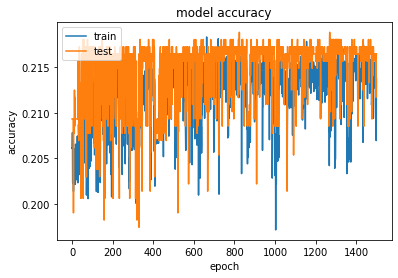

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()